# Syntactic score functions

## Yes/No question classification

In [55]:
def is_yes_no_question(question):
    question = question.lower().strip()
    #purposely has space after words since it should be a word in itself as part of a sentence
    if question.startswith(('is ', 'are ', 'do ', 'does ', 'did ', 'was ', 'were ', 'will ', 'can ', 'could ', 'should ', 'have ', 'has ', 'had ')): 
        return 1
    else:
        return 0

def is_yes_no_answer(answer):
    answer = answer.lower().strip()
    if answer.startswith(('yes','no')):
        return 1
    else:
        return 0
    
# Test the function
sentences = [
    "Is this right?",
    "Which questions are you thinking of?",
    "Hassan",
    'Has an'
]

for sentence in sentences:
    is_yes_no = is_yes_no_question(sentence)
    print(f"Sentence: {sentence}")
    print(f"Is yes/no type question: {is_yes_no:.2f}\n")

Sentence: Is this right?
Is yes/no type question: 1.00

Sentence: Which questions are you thinking of?
Is yes/no type question: 0.00

Sentence: Hassan
Is yes/no type question: 0.00

Sentence: Has an
Is yes/no type question: 1.00



## Conciseness

In [116]:
import spacy
from nltk.tokenize import word_tokenize

# Load the spaCy model for linguistic features
nlp = spacy.load("en_core_web_sm")

def evaluate_conciseness(answer):
    # Tokenize the answer and analyze with spaCy
    doc = nlp(answer)
    word_count = len(word_tokenize(answer))

    # Calculate the ratio of content words (nouns, verbs, adjectives, adverbs) to total words
    content_words_count = sum(token.pos in [spacy.symbols.NOUN, spacy.symbols.VERB, spacy.symbols.ADJ, spacy.symbols.ADV] for token in doc)
    content_ratio = content_words_count / word_count if word_count else 0

    # Conciseness favors higher content ratio (more information with fewer words)
    conciseness_score = content_ratio

    # Adjusting score for extremely short answers
    # Extremely short answers (like 'yes' or 'no') are typically very concise
    if word_count <= 2:
        conciseness_score = max(conciseness_score, 0.9)

    # Adjusting score to be between 0 and 1
    conciseness_score = max(0, min(conciseness_score, 1))

    return conciseness_score


# Test the function
answers = [
    "Yes.",
    "The cat sat on the mat.",
    "This is a somewhat more elaborative answer providing detailed information, albeit not necessarily in a concise manner."
]

for answer in answers:
    score = evaluate_conciseness(answer)
    print(f"Answer: {answer}\nConciseness Score: {score:.2f}\n")

Answer: Yes.
Conciseness Score: 0.90

Answer: The cat sat on the mat.
Conciseness Score: 0.43

Answer: This is a somewhat more elaborative answer providing detailed information, albeit not necessarily in a concise manner.
Conciseness Score: 0.53



## Fluency

In [92]:
## FLUENCY

!pip install stanza
import spacy
import torch
import stanza

# Download and set up the Stanza pipeline
stanza.download('en')  # for English
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def evaluate_syntax_fluency(sentence):
    doc = nlp(sentence)

    if len(doc) == 0:
        return 0.0  # Empty sentence

    num_tokens = len(doc)
    if num_tokens <= 2:  # Penalize very short or fragmentary sentences
        return 0.5

    tree_depths = []
    unique_dependency_types = set()

    for token in doc:
        # Calculate depth of each token in the parse tree
        depth = 0
        current_token = token
        while current_token.head != current_token:
            depth += 1
            current_token = current_token.head
        tree_depths.append(depth)

        # Collect unique dependency types
        unique_dependency_types.add(token.dep_)

    # Metrics
    max_depth = max(tree_depths)
    depth_variety_score = len(unique_dependency_types) / num_tokens

    # Score calculation (adjusted heuristic)
    # Higher max depth might indicate complexity (lower fluency)
    # More variety in dependency types might indicate richer syntactic structure (higher fluency)
    fluency_score = (1 - (max_depth / (2 * num_tokens)) + depth_variety_score) / 2

    return fluency_score


# Test the function
sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "While the fox jumps, the dog barks.",
    "Fox."
]

for sentence in sentences:
    fluency_score = evaluate_syntax_fluency(sentence)
    print(f"Sentence: {sentence}")
    print(f"Syntax Fluency Score: {fluency_score:.2f}\n")

2023-11-26 11:14:40 INFO: Downloading default packages for language: en (English) ...
2023-11-26 11:14:42 INFO: File exists: C:\Users\pabma\stanza_resources\en\default.zip
2023-11-26 11:14:45 INFO: Finished downloading models and saved to C:\Users\pabma\stanza_resources.
2023-11-26 11:14:45 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-11-26 11:14:45 WARNING: Can not find mwt: default from official model list. Ignoring it.
2023-11-26 11:14:46 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2023-11-26 11:14:46 INFO: Using device: cuda
2023-11-26 11:14:46 INFO: Loading: tokenize
2023-11-26 11:14:46 INFO: Loading: pos
2023-11-26 11:14:46 INFO: Loading: lemma
2023-11-26 11:14:46 INFO: Loading: depparse
2023-11-26 11:14:46 INFO: Done loading processors!


Sentence: The quick brown fox jumps over the lazy dog.
Syntax Fluency Score: 0.77

Sentence: While the fox jumps, the dog barks.
Syntax Fluency Score: 0.81

Sentence: Fox.
Syntax Fluency Score: 0.50



## Syntactic score

In [120]:
def syntactic_score(question, answer, weights_IS_yes_no=[1,1,1], weights_NOT_yes_no=[1,1,1], debug=False, extra_outputs='False'):
    
    #only question and answer are strictly required. Others are set to default values of equal weights, no print out and no additional outputs
    #weights of coherency, fluency and conciseness can be anything since they are scaled afterwards. Set equally by default
    #There are 2 sets of weights since answers to YES/NO type questions are not comparable to non Yes/No type

    is_yes_no_type=is_yes_no_question(question)
    coherency = 1 if is_yes_no_question(question) == is_yes_no_answer(answer) else 0
    fluency=evaluate_syntax_fluency(answer)
    conciseness=evaluate_conciseness(answer)
    
    #choose adequate weights for the case
    if is_yes_no_type==1:
        weights=weights_IS_yes_no   
    else:
        weights=weights_NOT_yes_no   

    #calulate score as weighted average
    syntactic_score=(coherency*weights[0]+fluency*weights[1]+conciseness*weights[2])/np.sum(weights)

    #print out for debug
    if debug==True:
        print('Q:',question,
              '|YES/NO TYPE:',is_yes_no_type, 
              '||A:',answer,
              '|COHERENCY(',weights[0],'):',coherency, 
              '|FLUENCY(',weights[1],'):', fluency, 
              '|CONCISENESS(',weights[2],'):',conciseness,
              '||SYNTACTIC SCORE:',syntactic_score
               ) 
    
    #return outputs
    if extra_outputs==True:
        return syntactic_score, is_yes_no_type, coherency, fluency, conciseness
    else:
        return syntactic_score

In [121]:
# Examples putting it all together
questions=['Are dogs pets?',
           'Is a dog a pet?',

           'Is it Saturday',
           'What day is it?',

           'Where are you going?',
           'Are you goind downtown?',

           'Did you forget?',
           'Have you forgotten?',

           'How long has it been?',
           'Has it been long?'
           ]

answers=['I dont know',
         'Yes it is',

         'It is not Saturday',
         'No',

         'Nowhere, stop asking',
         'YES!',
         
         'Maybe I did',
         'No. Stop bothering',

         'Its been very long since we last spoke',
         'No, not really']

# Test the function
for i in range(len(questions)):
    syntactic_score_=syntactic_score(questions[i],answers[i],debug=True)

Q: Are dogs pets? |YES/NO TYPE: 1 ||A: I dont know |COHERENCY( 1 ): 0 |FLUENCY( 1 ): 0.9375 |CONCISENESS( 1 ): 0.3333333333333333 ||SYNTACTIC SCORE: 0.4236111111111111
Q: Is a dog a pet? |YES/NO TYPE: 1 ||A: Yes it is |COHERENCY( 1 ): 1 |FLUENCY( 1 ): 0.9166666666666667 |CONCISENESS( 1 ): 0 ||SYNTACTIC SCORE: 0.638888888888889
Q: Is it Saturday |YES/NO TYPE: 1 ||A: It is not Saturday |COHERENCY( 1 ): 0 |FLUENCY( 1 ): 0.9375 |CONCISENESS( 1 ): 0 ||SYNTACTIC SCORE: 0.3125
Q: What day is it? |YES/NO TYPE: 0 ||A: No |COHERENCY( 1 ): 0 |FLUENCY( 1 ): 0.5 |CONCISENESS( 1 ): 0.9 ||SYNTACTIC SCORE: 0.4666666666666666
Q: Where are you going? |YES/NO TYPE: 0 ||A: Nowhere, stop asking |COHERENCY( 1 ): 0 |FLUENCY( 1 ): 0.9375 |CONCISENESS( 1 ): 0.75 ||SYNTACTIC SCORE: 0.5625
Q: Are you goind downtown? |YES/NO TYPE: 1 ||A: YES! |COHERENCY( 1 ): 1 |FLUENCY( 1 ): 0.5 |CONCISENESS( 1 ): 0.9 ||SYNTACTIC SCORE: 0.7999999999999999
Q: Did you forget? |YES/NO TYPE: 1 ||A: Maybe I did |COHERENCY( 1 ): 0 |FL

# QA Dataset application

## Dataloader

In [14]:
# Change to appropriate local file path
%cd '/content/drive/MyDrive/2023-FALL/11-611 NLP/NLP Project Ideas'

[WinError 3] The system cannot find the path specified: "'/content/drive/MyDrive/2023-FALL/11-611 NLP/NLP Project Ideas'"
h:\My Drive\2023-FALL\11-611 NLP\Project


In [15]:

import torch
from torch.utils.data import Dataset
import os
import numpy as np


class CustomData(Dataset):

    def __init__(self, file_dir):
        self.file = file_dir
        self.article_name = []
        self.questions = []
        self.answers = []
        self.q_diffi = []
        self.a_diffi = []
        self.article_path = []
        self.context = {} # only fill when load the dataset

        # get question answer pairs
        for div in ['S08', 'S09', 'S10']:
          skip = True
          qa_path = os.path.join(self.file, div, "question_answer_pairs.txt")
          with open(qa_path, 'rb') as f:
            for line in f:
              if skip:
                skip = False
                continue
              try:
                row = line.decode().split('\t')
              except:
                continue
              # print(row)
              if "NULL" in row:
                continue # if any feature does not exist -> skip
              self.article_name.append(row[0])
              self.questions.append(row[1])
              self.answers.append(row[2])
              self.q_diffi.append(row[3])
              self.a_diffi.append(row[4])
              self.article_path.append(div + "/"+ row[5][:-1]) # get rid of '\n

        print("length of dataset: ", len(self.questions))


    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):

        # retrieve context here -> less mem storage overhead
        try:
          curr_context = self.context[self.article_name[idx]]
        except KeyError:
          context_file = self.file + "/" + self.article_path[idx] + ".txt"
          # read all content, including the related items
          with open(context_file, 'rb') as f:
            curr_context = f.read().decode().replace('\n',' ')
          self.context[self.article_name[idx]] = curr_context

        #return self.questions[idx], self.answers[idx], curr_context
        return (self.article_name[idx],
                self.questions[idx],
                self.answers[idx],
                self.q_diffi[idx],
                self.a_diffi[idx],
                self.article_path[idx],
                curr_context
                )


In [110]:
# Load data using CustomData function
data_path = 'Question_Answer_Dataset_v1.2'
dataset = CustomData(data_path)
# Print random set for data exploration
n=len(dataset)
n_show=1

rand_range=np.random.randint(0,n,n_show)

for line in rand_range:
  d = dataset[line] #
  print('line:',line)
  print("article_name: ", d[0])
  print("question: ", d[1])
  print(' question length:',len(d[1]))
  print("answer: ", d[2])
  print(' answer length:', len(d[2]))
  print("q_diffi: ", d[3])
  print("a_diffi: ", d[4])
  print("article_path: ", d[5])
  print("article: ", d[6])
  print(' article length:',len(d[6]))
  print('\n')

length of dataset:  2725
line: 616
article_name:  kangaroo
question:  What is responsible for converting the hydrogen byproduct of fermentation into acetate?
 question length: 87
answer:  The digestive system of a kangaroo
 answer length: 34
q_diffi:  hard
a_diffi:  too hard
article_path:  S08/data/set1/a1
article:  kangaroo  :For other uses, see kangaroo (disambiguation).  A kangaroo is a marsupial from the family Macropodidae (macropods, meaning 'large foot'). In common use the term is used to describe the largest species from this family, the Red Kangaroo, the Antilopine Kangaroo, and the Eastern and Western Grey Kangaroo of the Macropus genus. The family also includes many smaller species which include the wallabies, tree-kangaroos, wallaroos, pademelons and the Quokka, some 63 living species in all.  Kangaroos are endemic to the continent of Australia, while the smaller macropods are found in Australia and New Guinea.  In general, larger kangaroos have adapted much better to chang

## Syntactic score application

In [113]:
'''
- [0] article_name   
- [1] question   
- [2] answer  
- [3] difficulty by question maker
- [4] difficulty by answer maker
- [5] article path
- [6] article text
'''

import random

#make random selection
n=50 #random sample to get from len(dataset)  
random_select=random.sample(range(len(dataset)), n) #Sometime fails because of UTF 

In [122]:
# Get scores
scores=[]
for line in random_select: #range(n):
    q=dataset[line][1]
    a=dataset[line][2]
    print('difficulty:',dataset[line][3],dataset[line][4])
   
    scores.append(syntactic_score(q, #question
                                  a, #answer
                                  weights_IS_yes_no=[1,0,1], #weights of coherency, fluency and conciseness in case of Yes/No type question
                                  weights_NOT_yes_no=[0,2,1], #weights of coherency, fluency and conciseness in case of NOT Yes/No type question
                                  debug=True, #print out for debugging
                                  extra_outputs=True) #output syntactic score, coherency, fluency, conciseness (last 3 are the 'extra')
                                  ) 



difficulty: medium medium
Q: How many years after Cleveland left office did the U.S. win the Spanish-American War? |YES/NO TYPE: 0 ||A: One Year |COHERENCY( 0 ): 1 |FLUENCY( 2 ): 0.5 |CONCISENESS( 1 ): 0.9 ||SYNTACTIC SCORE: 0.6333333333333333
difficulty: easy hard
Q: Did Charles-Augustin de Coulomb find any relationship between electric charges and magnetic poles?  |YES/NO TYPE: 1 ||A: No |COHERENCY( 1 ): 1 |FLUENCY( 0 ): 0.5 |CONCISENESS( 1 ): 0.9 ||SYNTACTIC SCORE: 0.95
difficulty: easy easy
Q: Is Vietnamese the official administrative language of Vietnam? |YES/NO TYPE: 1 ||A: Yes. |COHERENCY( 1 ): 1 |FLUENCY( 0 ): 0.5 |CONCISENESS( 1 ): 0.9 ||SYNTACTIC SCORE: 0.95
difficulty: medium medium
Q: Which state were Coolidge born in? |YES/NO TYPE: 0 ||A: Plymouth, Windsor County, Vermont |COHERENCY( 0 ): 1 |FLUENCY( 2 ): 0.8333333333333334 |CONCISENESS( 1 ): 0 ||SYNTACTIC SCORE: 0.5555555555555556
difficulty: medium medium
Q: Some versions of xylophones have resonators made of what? |YES/

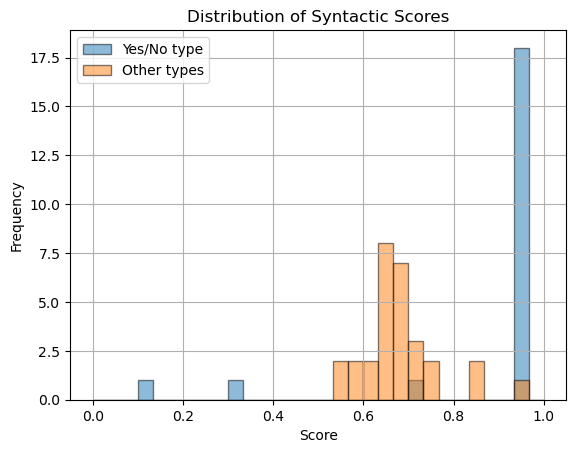

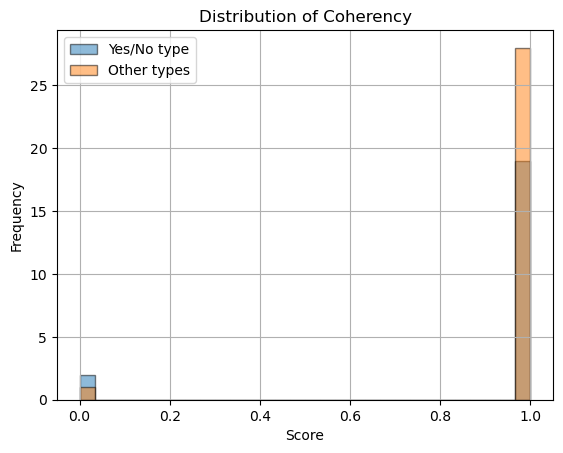

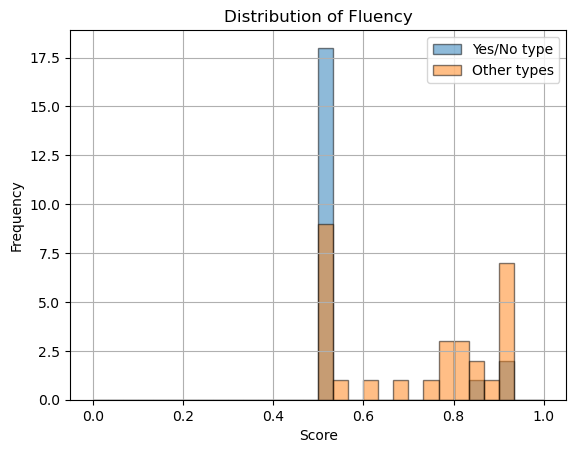

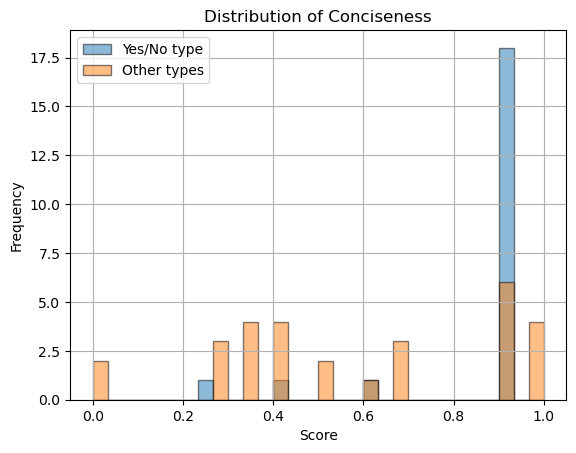

In [137]:
# Score distribution

import numpy as np
import matplotlib.pyplot as plt

#syntactic_score, is_yes_no_type, coherency, fluency, conciseness
#histogram of score
scores=np.array(scores)
ind_yn=scores[:,1]==1 #Yes/No type

plt.hist(scores[ind_yn,0], bins=30, range=(0,1), edgecolor='black', alpha=0.5, label='Yes/No type')
plt.hist(scores[~ind_yn,0], bins=30, range=(0,1), edgecolor='black', alpha=0.5, label='Other types')
plt.title('Distribution of Syntactic Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

#histogram of coherency

plt.hist(scores[ind_yn,2], bins=30, range=(0,1), edgecolor='black', alpha=0.5, label='Yes/No type')
plt.hist(scores[~ind_yn,2], bins=30, range=(0,1), edgecolor='black', alpha=0.5, label='Other types')
plt.title('Distribution of Coherency')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

#histogram of fluency

plt.hist(scores[ind_yn,3], bins=30, range=(0,1), edgecolor='black', alpha=0.5, label='Yes/No type')
plt.hist(scores[~ind_yn,3], bins=30, range=(0,1), edgecolor='black', alpha=0.5, label='Other types')
plt.title('Distribution of Fluency')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

#histogram of conciseness

plt.hist(scores[ind_yn,4], bins=30, range=(0,1), edgecolor='black', alpha=0.5, label='Yes/No type')
plt.hist(scores[~ind_yn,4], bins=30, range=(0,1), edgecolor='black', alpha=0.5, label='Other types')
plt.title('Distribution of Conciseness')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

In [129]:
ind_rows=scores[:,1]==1

print(np.sum(ind_rows),len(scores))

21 50


In [139]:
# case study

'''
difficulty: medium medium
Q: What is Avogadro most noted for? |YES/NO TYPE: 0 ||A: contributions to the theory of molarity and molecular weight |COHERENCY( 1 ): 1 |FLUENCY( 1 ): 0.7222222222222223 |CONCISENESS( 1 ): 0.5555555555555556 ||SYNTACTIC SCORE: 0.7592592592592592 

difficulty: easy easy
Q: Are turtles a part of the Flying Spaghetti Monster? |YES/NO TYPE: 1 ||A: *shrug* |COHERENCY( 1 ): 0 |FLUENCY( 1 ): 0.75 |CONCISENESS( 1 ): 0.6666666666666666 ||SYNTACTIC SCORE: 0.47222222222222215

difficulty: easy hard
Q: Are cougars larger than jaguars? |YES/NO TYPE: 1 ||A: Cougars are not larger than jaguars. |COHERENCY( 1 ): 0 |FLUENCY( 1 ): 0.8928571428571428 |CONCISENESS( 1 ): 0.42857142857142855 ||SYNTACTIC SCORE: 0.44047619047619047 

difficulty: medium medium
Q: What did Jefferson call John Adams? |YES/NO TYPE: 0 ||A: Colossus of Independence |COHERENCY( 1 ): 1 |FLUENCY( 1 ): 0.8333333333333334 |CONCISENESS( 1 ): 0 ||SYNTACTIC SCORE: 0.6111111111111112 

difficulty: medium medium
Q: Where is Uruguay's oldest church? |YES/NO TYPE: 0 ||A: San Carlos, Maldonado. |COHERENCY( 1 ): 1 |FLUENCY( 1 ): 0.8500000000000001 |CONCISENESS( 1 ): 0 ||SYNTACTIC SCORE: 0.6166666666666667 

difficulty: easy easy
Q: Are giraffes hunted for their hides? |YES/NO TYPE: 1 ||A: Yes |COHERENCY( 1 ): 1 |FLUENCY( 1 ): 0.5 |CONCISENESS( 1 ): 0.9 ||SYNTACTIC SCORE: 0.7999999999999999 

difficulty: medium medium
Q: What is Avogadro most noted for? |YES/NO TYPE: 0 ||A: contributions to the theory of molarity and molecular weight |COHERENCY( 1 ): 1 |FLUENCY( 1 ): 0.7222222222222223 |CONCISENESS( 1 ): 0.5555555555555556 ||SYNTACTIC SCORE: 0.7592592592592592 
'''

q='Are cougars larger than jaguars?'
a1='Cougars are not larger than jaguars.'
a2='Yes they are.'
a3='No.'

#weights of coherency, fluency and conciseness
syntactic_score(q,a1,weights_IS_yes_no=[1,1,1],weights_NOT_yes_no=[1,1,1],debug=True)
syntactic_score(q,a2,weights_IS_yes_no=[1,1,1],weights_NOT_yes_no=[1,1,1],debug=True)
syntactic_score(q,a3,weights_IS_yes_no=[1,1,1],weights_NOT_yes_no=[1,1,1],debug=True)
print('')
syntactic_score(q,a1,weights_IS_yes_no=[1,0,1],weights_NOT_yes_no=[0,2,1],debug=True)
syntactic_score(q,a2,weights_IS_yes_no=[1,0,1],weights_NOT_yes_no=[0,2,1],debug=True)
syntactic_score(q,a3,weights_IS_yes_no=[1,0,1],weights_NOT_yes_no=[0,2,1],debug=True)


Q: Are cougars larger than jaguars? |YES/NO TYPE: 1 ||A: Cougars are not larger than jaguars. |COHERENCY( 1 ): 0 |FLUENCY( 1 ): 0.8928571428571428 |CONCISENESS( 1 ): 0.42857142857142855 ||SYNTACTIC SCORE: 0.44047619047619047
Q: Are cougars larger than jaguars? |YES/NO TYPE: 1 ||A: Yes they are. |COHERENCY( 1 ): 1 |FLUENCY( 1 ): 0.9375 |CONCISENESS( 1 ): 0 ||SYNTACTIC SCORE: 0.6458333333333334
Q: Are cougars larger than jaguars? |YES/NO TYPE: 1 ||A: No. |COHERENCY( 1 ): 1 |FLUENCY( 1 ): 0.5 |CONCISENESS( 1 ): 0.9 ||SYNTACTIC SCORE: 0.7999999999999999

Q: Are cougars larger than jaguars? |YES/NO TYPE: 1 ||A: Cougars are not larger than jaguars. |COHERENCY( 1 ): 0 |FLUENCY( 0 ): 0.8928571428571428 |CONCISENESS( 1 ): 0.42857142857142855 ||SYNTACTIC SCORE: 0.21428571428571427
Q: Are cougars larger than jaguars? |YES/NO TYPE: 1 ||A: Yes they are. |COHERENCY( 1 ): 1 |FLUENCY( 0 ): 0.9375 |CONCISENESS( 1 ): 0 ||SYNTACTIC SCORE: 0.5
Q: Are cougars larger than jaguars? |YES/NO TYPE: 1 ||A: No. |

0.95